# Load water level data from DMI

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
from anomalydetection.detectors import AnomalyDetectionPipeline, RangeDetector, DiffRangeDetector, RollingStdDetector

In [4]:
file_path = os.path.join("..", "tests", "data", "Ballen_20150218-20201222.csv")
df = pd.read_csv(file_path, index_col=0, parse_dates=True)
data = df.water_level

# Detect anomalies outside manually set range

In [ ]:
range_anomalies = RangeDetector(-1, 1).detect(data)

In [ ]:
detected = data.to_frame()
detected["anomalies"] = data[range_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(8,3))

# Detect anomalies outside automatically set range

In [ ]:
N = 1000
normal_data, test_data = data[:N], data[N:]

In [ ]:
anomaly_detector = AnomalyDetectionPipeline([RangeDetector(), DiffRangeDetector()])
anomaly_detector.fit(normal_data)
detected_anomalies = anomaly_detector.detect_detailed(test_data)

In [ ]:
detected_anomalies.head()

In [ ]:
detected = test_data.to_frame()
detected["anomalies"] = test_data[detected_anomalies.is_anomaly]
detected.plot(style=['-', 'o'], figsize=(8,3))

# Detect anomalies outside rolling std

In [5]:
detector = RollingStdDetector(10, 0.1)
std_anomalies = detector.detect(data)
std_anomalies[0] = False

<IPython.core.display.Javascript object>


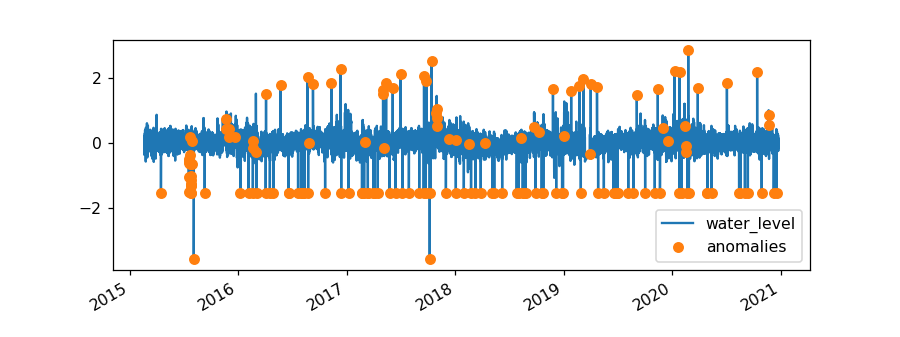

<AxesSubplot:>

In [6]:
detected = data.to_frame()
detected["anomalies"] = data[std_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(8,3))

In [ ]:
s = (data.rolling(10).std() > 0.1).astype(int).diff() > 0

In [ ]:
std_anomalies = s.fillna(False)

In [ ]:
s = (data.rolling(10).std() > 0.1).diff()